In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
# preparing data
from models import *
from methods import *
import pandas as pd
import torch
import os
from os import path
from sklearn.manifold import TSNE
from datasetPreProcessing import LoadDatasetByName

#DATASET = 'ECU_IoHT_data'
DATASET = 'medical_full_data'
"""___________________Hyper Parameters________________________"""
MODEL_NAME = ['AE']
CROSS_VALIDATION_SHUFFLE = True
TRIM_DATA = [False]
FILTER_CORRCOEF = [False]
REMOVE_NOISE = [False]
NOISE_THRESHOLD = [5]
DENOISE = [False]
NOISE_FACTOR = [0.2]
NOISE_FRACTION = [0.2]
PERPLEXITY = 10
NORMALIZE_DATA = [True]
NORMALIZATION_SCHEME = ['standard_scaling']
#NORMALIZATION_SCHEME = ['standard_scaling', 'robust_scaling', 'min_max_scaling', 'max_abs_scaling', 'power_transformation_yj', 'quantile_transform_normal']

INITIALIZATION = ['xavier_normal']
ACTIVATION = ['leaky_relu']
SIGMA = [1]
LATENT_DIM = [64]
HIDDEN_DIM = [64]
GD_ALGORITHMS = ['SGD']
WEIGHT_DECAY = [0, 1e-7, 1e-6]
LEARNING_RATE = [1e-4]
BATCH_SIZE = [1024]
EPOCHS = [3000]
ATTENTION = False
OVER_SAMPLING = True
"""___________________________________________________________"""
# Load Dataset
raw_data, anomalous_raw, features, categorical_data_index = LoadDatasetByName(DATASET)

print(raw_data.shape, anomalous_raw.shape)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
idc = [0,1]
idc = None
if idc:
    raw_data, anomalous_raw = raw_data[:,idc], anomalous_raw[:,idc]
specificity_list, recall_list = [], []

(13343, 7) (2046, 7)


In [4]:
import itertools

# Different types of model
for model_name in MODEL_NAME:
    # Data Processing
    for trim_data, normalize_data, normalization_scheme, filter_corrcoef, remove_noise, noise_threshold in itertools.product(TRIM_DATA, NORMALIZE_DATA, NORMALIZATION_SCHEME, FILTER_CORRCOEF, REMOVE_NOISE, NOISE_THRESHOLD):
        # initialize containers for data
        loss_array = []
        # process data
        train_X, train_Y, test_X, test_Y = preProcessData_LogisticRegression(raw_data, anomalous_raw, trim=trim_data, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
            filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold, categorical_data_index=categorical_data_index, over_sampling=OVER_SAMPLING)
        #
        train_X, train_Y, test_X, test_Y = toTorchTensor(device, train_X, train_Y, test_X, test_Y)
        criterion = nn.BCELoss(reduction='sum').to(device)
        NUM_FEATURE = train_X.shape[-1]
        attNet = None
        if ATTENTION:
            attNet = AttentionNet(num_feature=NUM_FEATURE, sample_size=len(train_X), E_dim=NUM_FEATURE)
            NUM_FEATURE = attNet.E_Dim
        
        for latent_dim, hidden_dim, activation, initialization, sigma in itertools.product(LATENT_DIM, HIDDEN_DIM, ACTIVATION, INITIALIZATION, SIGMA):
            for algo, learning_rate, weight_decay, epochs, batch_size, noise_factor, noise_fraction in itertools.product(GD_ALGORITHMS, LEARNING_RATE, WEIGHT_DECAY, EPOCHS, BATCH_SIZE, NOISE_FACTOR, NOISE_FRACTION):
                # initialize model
                if model_name == 'AE':
                    model = Discriminator(num_feature=NUM_FEATURE, latent_dim=latent_dim, hidden_dim=hidden_dim, activation=activation, initialization=initialization, logit=True).to(device)
                # train 
                print(train_X.shape, train_Y.shape)
                criterion.reduction = 'sum'
                loss_array = train(model, 'SGD', epochs, train_X, train_Y, criterion, batch_size=batch_size, lr=learning_rate, weight_decay=weight_decay
                    , grad_limit=1e1, att=attNet)
                torch.save(model.state_dict(), '../model/param_AE')
                
                criterion.reduction = 'none'
                if ATTENTION:
                    train_X, test_X = attNet.transformData(train_X), attNet.transformData(test_X)
                    print(torch.diag(attNet.weights))
                
                # test
                y_scores_loss, y_ground_truth = test_classification(model, criterion, test_X, test_Y)
                # plot
                # parameters for visualizer to print
                parameters = {"data_set:":DATASET,
                    "trim_data": trim_data, "normalize_data": normalize_data, "normalization_scheme": normalization_scheme,
                    "filter_corrcoef": filter_corrcoef, "remove_noise": remove_noise, "noise_threshold": noise_threshold,
                    
                    "latent_dim": latent_dim, "hidden_dim": hidden_dim,
                    "activation": activation, "initialization": initialization,

                    "GD algorithm": algo,
                    "weight_decay": weight_decay,
                    "learning_rate": learning_rate,
                    "batch_size": batch_size,
                    "epochs": epochs,
                    "attention": ATTENTION,
                    }
                if model.name == 'VAE':
                    parameters["sigma"] = sigma
                if model.name == 'DAE':
                    parameters["denoise"] = True
                    parameters["noise_factor"] = noise_factor
                    parameters["noise_fraction"] = noise_fraction  
                pred_threshold = 0.5
                ##
                parameters["Train precision"] = torch.sum(torch.logical_and((model(train_X) > pred_threshold), (train_Y == 1))) / torch.sum(model(train_X) > pred_threshold)
                parameters["Train recall"] = torch.sum(torch.logical_and((model(train_X) > pred_threshold), (train_Y == 1))) / torch.sum(train_Y == 1)
                parameters["Test precision"] = torch.sum(torch.logical_and((model(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(model(test_X) > pred_threshold)
                parameters["Test recall"] = torch.sum(torch.logical_and((model(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(test_Y == 1)
                scores = {"y_scores_loss": y_scores_loss}
                visualize_ROC(y_ground_truth, model.name, True, scores, save_path="../graphs/logit/ROC", **parameters)
                # test undetected medical data
                if DATASET == 'medical_data':
                    anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
                    _, _, _, test_X = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, trim_threshold=0.98, normalize=normalize_data,
                        filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold)
                    test_X = torch.tensor(test_X).to(torch.float).to(device)
                    test_Y = torch.ones(len(test_X), 1).to(torch.float).to(device)
                    parameters["Undetected data recall"] = torch.sum(torch.logical_and((model(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(test_Y == 1)
                # visualize
                visualize_convergence(loss_array, model.name, save=True, save_path="../graphs/logit/convergence", **parameters)
                plt.close('all')

Train data shape after trim:  (8005, 7)
Train data shape after filter corrcoef:  (8005, 7)
Normalization scheme:  standard_scaling
Train data shape after normalize:  (8005, 7)
train_X, train_Y shape: (21310, 7) (21310, 1)
test_X, test_Y shape: (3078, 7) (3078, 1)
torch.Size([21310, 7]) torch.Size([21310, 1])
epoch : 1/3000, loss = 0.693151
epoch : 2/3000, loss = 0.693136
epoch : 3/3000, loss = 0.693120
epoch : 4/3000, loss = 0.693110
epoch : 5/3000, loss = 0.693100
epoch : 6/3000, loss = 0.693089
epoch : 7/3000, loss = 0.693072
epoch : 8/3000, loss = 0.693064
epoch : 9/3000, loss = 0.693047
epoch : 10/3000, loss = 0.693039
epoch : 11/3000, loss = 0.693022
epoch : 12/3000, loss = 0.693005
epoch : 13/3000, loss = 0.692995
epoch : 14/3000, loss = 0.692972
epoch : 15/3000, loss = 0.692940
epoch : 16/3000, loss = 0.692907
epoch : 17/3000, loss = 0.692888
epoch : 18/3000, loss = 0.692851
epoch : 19/3000, loss = 0.692798
epoch : 20/3000, loss = 0.692752
epoch : 21/3000, loss = 0.692721
epoch 

In [5]:
criterion.reduction = 'none'
if ATTENTION:
    train_X, test_X = attNet.transformData(train_X), attNet.transformData(test_X)
    print(torch.diag(attNet.weights))

# test
y_scores_loss, y_ground_truth = test_classification(model, criterion, test_X, test_Y)
# plot
# parameters for visualizer to print
parameters = {"data_set:":DATASET,
    "trim_data": trim_data, "normalize_data": normalize_data, "normalization_scheme": normalization_scheme,
    "filter_corrcoef": filter_corrcoef, "remove_noise": remove_noise, "noise_threshold": noise_threshold,
    
    "latent_dim": latent_dim, "hidden_dim": hidden_dim,
    "activation": activation, "initialization": initialization,

    "GD algorithm": algo,
    "weight_decay": weight_decay,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "epochs": epochs,
    "attention": ATTENTION,
    }
if model.name == 'VAE':
    parameters["sigma"] = sigma
if model.name == 'DAE':
    parameters["denoise"] = True
    parameters["noise_factor"] = noise_factor
    parameters["noise_fraction"] = noise_fraction  
pred_threshold = 0.8
##
parameters["Train precision"] = torch.sum(torch.logical_and((model(train_X) > pred_threshold), (train_Y == 1))) / torch.sum(model(train_X) > pred_threshold)
parameters["Train recall"] = torch.sum(torch.logical_and((model(train_X) > pred_threshold), (train_Y == 1))) / torch.sum(train_Y == 1)
parameters["Test precision"] = torch.sum(torch.logical_and((model(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(model(test_X) > pred_threshold)
parameters["Test recall"] = torch.sum(torch.logical_and((model(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(test_Y == 1)
parameters["Test specificity"] = torch.sum(torch.logical_and((model(test_X) < pred_threshold), (test_Y == 0))) / torch.sum(test_Y == 0)
scores = {"y_scores_loss": y_scores_loss}
visualize_ROC(y_ground_truth, model.name, True, scores, save_path="../graphs/logit/ROC", **parameters)
# test undetected medical data
if DATASET == 'medical_data':
    anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
    _, _, _, test_X = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, trim_threshold=0.98, normalize=normalize_data,
        filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold)
    test_X = torch.tensor(test_X).to(torch.float).to(device)
    test_Y = torch.ones(len(test_X), 1).to(torch.float).to(device)
    parameters["Undetected data recall"] = torch.sum(torch.logical_and((model(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(test_Y == 1)
# visualize
visualize_convergence(loss_array, model.name, save=True, save_path="../graphs/logit/convergence", **parameters)
plt.close('all')

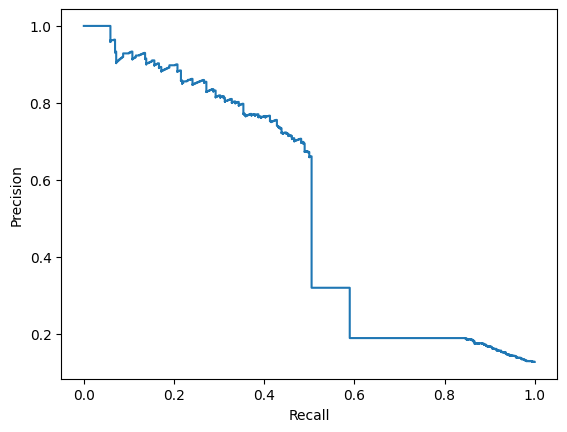

0.1553922210978942
0.7797404418498168


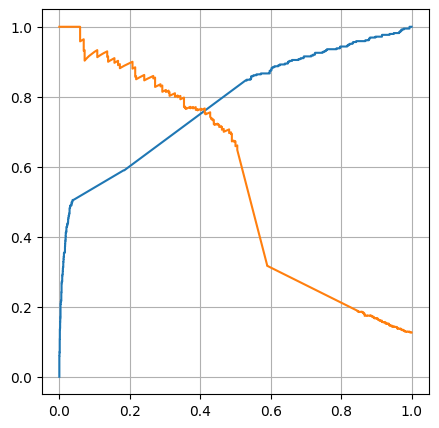

In [12]:
# metrics
from sklearn import metrics
loss = model(test_X).detach().numpy()
precision, recall, _ = metrics.precision_recall_curve(test_Y.numpy(), loss)
fpr, tpr, _ = metrics.roc_curve(test_Y.numpy(), loss)
disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()
print(metrics.auc(recall, precision))
print(metrics.auc(fpr, tpr))

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(1,1,1) 
ax.grid()
ax.plot(fpr, tpr)
ax.plot(recall, precision)

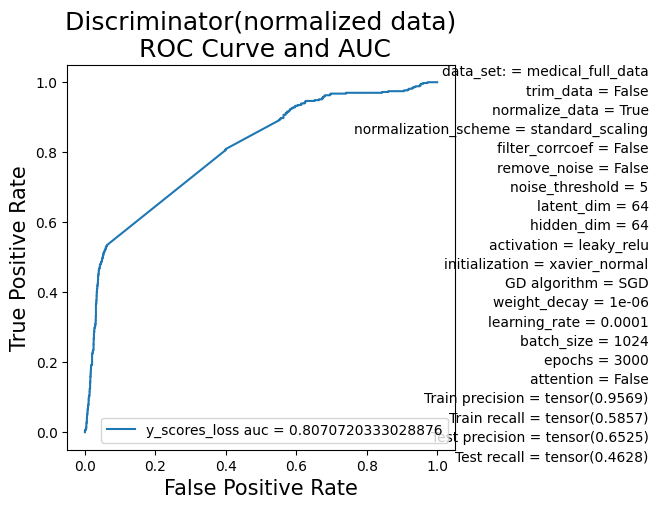

In [ ]:
# Visualize
# criterion.reduction = 'none'
y_scores_loss, y_ground_truth = test_classification(model, criterion, test_X, test_Y)
print()
scores = {"y_scores_loss": y_scores_loss}
visualize_ROC(y_ground_truth, model.name, True, scores, save_path="../graphs/logit/ROC", **parameters)


In [ ]:
if ATTENTION:
    print(torch.diag(attNet.weights))
print(parameters)

{'data_set:': 'medical_full_data', 'trim_data': False, 'normalize_data': True, 'normalization_scheme': 'standard_scaling', 'filter_corrcoef': False, 'remove_noise': False, 'noise_threshold': 5, 'latent_dim': 64, 'hidden_dim': 64, 'activation': 'leaky_relu', 'initialization': 'xavier_normal', 'GD algorithm': 'SGD', 'weight_decay': 1e-06, 'learning_rate': 0.0001, 'batch_size': 1024, 'epochs': 3000, 'attention': False, 'Train precision': tensor(0.9569), 'Train recall': tensor(0.5857), 'Test precision': tensor(0.6525), 'Test recall': tensor(0.4628)}
